<a href="https://colab.research.google.com/github/anuz505/Brain-Tumor-Image-Segmentation-using-UNet/blob/main/Brain_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>










































# 0. Change the Runtime to GPU

Runtime -> Change runtime type -> "T4 GPU" -> Save

# 1. Importing the Segmentation Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# View the content of the dataset

### Start Code Here
!ls /content/drive/MyDrive/kaggle_3m

### End

data.csv	       TCGA_DU_6400_19830518  TCGA_DU_A5TP_19970614  TCGA_HT_7680_19970202
README.md	       TCGA_DU_6401_19831001  TCGA_DU_A5TR_19970726  TCGA_HT_7684_19950816
TCGA_CS_4941_19960909  TCGA_DU_6404_19850629  TCGA_DU_A5TS_19970726  TCGA_HT_7686_19950629
TCGA_CS_4942_19970222  TCGA_DU_6405_19851005  TCGA_DU_A5TT_19980318  TCGA_HT_7690_19960312
TCGA_CS_4943_20000902  TCGA_DU_6407_19860514  TCGA_DU_A5TU_19980312  TCGA_HT_7692_19960724
TCGA_CS_4944_20010208  TCGA_DU_6408_19860521  TCGA_DU_A5TW_19980228  TCGA_HT_7693_19950520
TCGA_CS_5393_19990606  TCGA_DU_7008_19830723  TCGA_DU_A5TY_19970709  TCGA_HT_7694_19950404
TCGA_CS_5395_19981004  TCGA_DU_7010_19860307  TCGA_EZ_7264_20010816  TCGA_HT_7855_19951020
TCGA_CS_5396_20010302  TCGA_DU_7013_19860523  TCGA_FG_5962_20000626  TCGA_HT_7856_19950831
TCGA_CS_5397_20010315  TCGA_DU_7014_19860618  TCGA_FG_5964_20010511  TCGA_HT_7860_19960513
TCGA_CS_6186_20000601  TCGA_DU_7018_19911220  TCGA_FG_6688_20020215  TCGA_HT_7874_19950902
TCGA_CS_6188

In [ ]:
import os
import glob
import random

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

plt.style.use("dark_background")

In [ ]:
### Start Code Here
ROOT_DIR ="/content/drive/MyDrive/kaggle_3m"
### End

In [ ]:
# Make objects with the images and masks
import glob

brain_scans = []
mask_files = glob.glob(f'{ROOT_DIR}/*/*_mask*')

for i in mask_files:
    brain_scans.append(i.replace('_mask',''))

# Print 10 input and mask files
print(brain_scans[:10])
print(mask_files[:10])

['/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_10.tif', '/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_12.tif', '/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_19.tif', '/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_4.tif', '/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_21.tif', '/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_13.tif', '/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_9.tif', '/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_3.tif', '/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_2.tif', '/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_8.tif']
['/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_19960513/TCGA_HT_7860_19960513_10_mask.tif', '/content/drive/MyDrive/kaggle_3m/TCGA_HT

In [ ]:
# Make a dataframe with the images and their corresponding masks
import pandas as pd

### Start Code Here
img_df = pd.DataFrame({
    "image_path":brain_scans,
    "mask_path":mask_files
})
### End
print(img_df.head(5))

                                          image_path  \
0  /content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...   
1  /content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...   
2  /content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...   
3  /content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...   
4  /content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...   

                                           mask_path  
0  /content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...  
1  /content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...  
2  /content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...  
3  /content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...  
4  /content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...  


In [ ]:
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0# How many non-tumors (0) and tumors (1) are in the data

def process_images(mask_paths):
    results = []
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(positiv_negativ_diagnosis, mask_paths), total=len(mask_paths)))
    return results

# Apply the function to the masks and return back a column with 1 and zeros, where 0 indicates no tumor and 1 a tumor
img_df["diagnosis"] = process_images(img_df["mask_path"].tolist())
img_df.head()

  0%|          | 0/3929 [00:00<?, ?it/s]

,image_path,mask_path,diagnosis
0,/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...,/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...,0
1,/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...,/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...,0
2,/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...,/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...,0
3,/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...,/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...,0
4,/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...,/content/drive/MyDrive/kaggle_3m/TCGA_HT_7860_...,0


# 2. Data Visualization

In [ ]:
# How many non-tumors (0) and tumors (1) are in the data
img_df['diagnosis'].value_counts()

diagnosis
0    2556
1    1373
Name: count, dtype: int64

### Plot the MRI, Mask and overlay image

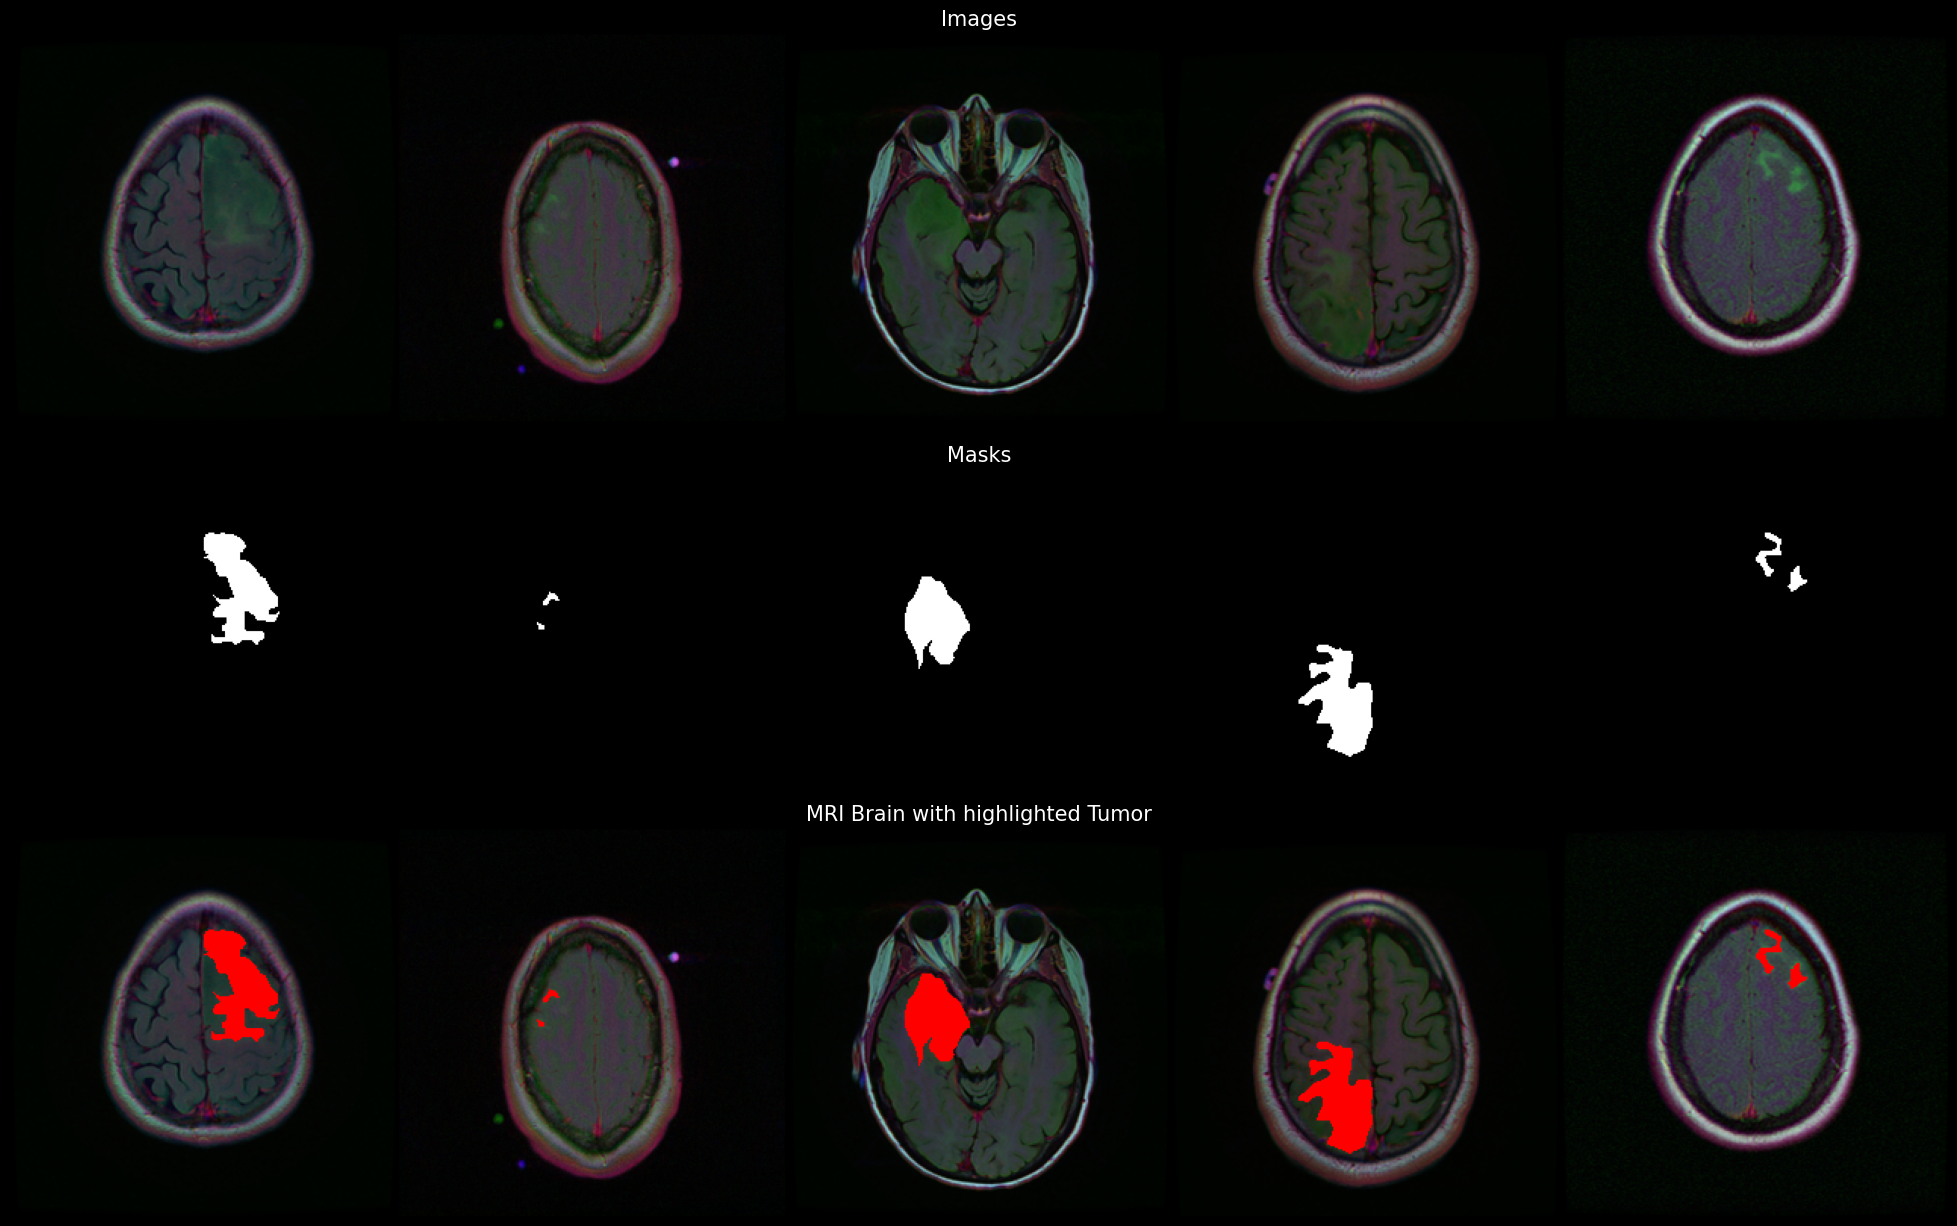

In [ ]:
from mpl_toolkits.axes_grid1.axes_grid import ImageGrid
# Data
sample_df = img_df[img_df["diagnosis"] == 1].sample(5).values
sample_imgs = []

for i, data in enumerate(sample_df):
    img = cv2.resize(cv2.imread(data[0]), (256, 256))
    mask = cv2.resize(cv2.imread(data[1]), (256, 256))
     # Plot the Brain MRI scan with their mask
    main = img.copy()
    sample = np.array(np.squeeze(mask), dtype = np.uint8)
    contours, hier = cv2.findContours(sample[:,:,0],cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_gt = cv2.drawContours(main, contours, -1,[255,0,0], thickness=-1)

    sample_imgs.extend([img, mask, sample_over_gt])

sample_imgs_arr = np.hstack(np.array(sample_imgs[::3]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::3]))
sample_over_gt_arr = np.hstack(np.array(sample_imgs[2::3]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 1),  # creates 3x1 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")

grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")

grid[2].imshow(sample_over_gt_arr)
grid[2].set_title("MRI Brain with highlighted Tumor", fontsize=15)
grid[2].axis("off")

plt.show()


# 3. Dataset split and DataLoaders

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.model_selection import train_test_split

class BrainMRIDataset(Dataset):
    def __init__(self, df, transforms):

        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        mask = cv2.imread(self.df.iloc[idx, 1], 0)

        # Normalize mask from 0-255 to 0-1
        ### Start Code Here
        mask = mask/255.0

        augmented = self.transforms(
            image=image,
            mask=mask
            )
        ### End

        image = augmented['image']
        mask = augmented['mask']

        return image, mask

## Image transformation

In [ ]:
### Start Code Here
transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    A.Normalize(p=1.0),
    ToTensorV2(),
])
### End

## Train and test data split

In [ ]:
### Start Code Here
# Split df into train_df and val_df
train_df, val_df = train_test_split(img_df,stratify=img_df.diagnosis,test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df,stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

test_df = test_df.reset_index(drop=True)
### End
#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 3) 
Val: (393, 3) 
Test: (531, 3)


## Dataloader

In [ ]:
# train
import multiprocessing
num_workers = multiprocessing.cpu_count()
batch_size = 4

### Start Code Here
train_dataset = BrainMRIDataset(df=train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# val
val_dataset = BrainMRIDataset(df=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

#test
test_dataset = BrainMRIDataset(df=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
### End

# 4. UNet Model

In [ ]:
import torch
from torch import nn

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)


cuda


In [ ]:
class VanillaUNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()

        ### Start Code Here
        self.conv_down1 = self.double_conv(3,64)
        self.conv_down2 = self.double_conv(64, 128)
        self.conv_down3 = self.double_conv(128, 256)
        self.conv_down4 = self.double_conv(256,512)
        ### End

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = self.double_conv(256 + 512, 256)
        self.conv_up2 = self.double_conv(128 + 256, 128)
        self.conv_up1 = self.double_conv(128 + 64, 64)

        self.last_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        ### Start Code Here
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels,3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3 , padding=1),
            nn.ReLU(inplace=True),
            )
        ### End

    def forward(self, x):
        # Batch - 1d tensor.  N_channels - 1d tensor, IMG_SIZE - 2d tensor.
        # Example: x.shape >>> (10, 3, 256, 256).
        ### Start Code Here
        conv1 =self.conv_down1(x)   # <- BATCH, 3,   IMG_SIZE -> BATCH,  64, IMG_SIZE..
        x     = self.maxpool(conv1)                             # <- BATCH, 64,  IMG_SIZE -> BATCH,  64, IMG_SIZE 2x down.
        conv2 = self.conv_down2(x)                              # <- BATCH, 64,  IMG_SIZE -> BATCH, 128, IMG_SIZE.
        x     = self.maxpool(conv2)                             # <- BATCH, 128, IMG_SIZE -> BATCH, 128, IMG_SIZE 2x down.
        conv3 = self.conv_down3(x)                              # <- BATCH, 128, IMG_SIZE -> BATCH, 256, IMG_SIZE.
        x     = self.maxpool(conv3)                  # <- BATCH, 256, IMG_SIZE -> BATCH, 256, IMG_SIZE 2x down.
        x     = self.conv_down4(x)                              # <- BATCH, 256, IMG_SIZE -> BATCH, 512, IMG_SIZE.
        x     = self.upsample(x)                                # <- BATCH, 512, IMG_SIZE -> BATCH, 512, IMG_SIZE 2x up.

        #(Below the same)                                 N this       ==        N this.  Because the first N is upsampled.
        x    = torch.cat([x, conv3], dim=1)        # <- BATCH, 512, IMG_SIZE & BATCH, 256, IMG_SIZE--> BATCH, 768, IMG_SIZE.

        x    = self.conv_up3(x)                                 #  <- BATCH, 768, IMG_SIZE --> BATCH, 256, IMG_SIZE.
        x    = self.upsample(x)                                 #  <- BATCH, 256, IMG_SIZE -> BATCH,  256, IMG_SIZE 2x up.
        x    = torch.cat([x, conv2], dim=1)                     # <- BATCH, 256,IMG_SIZE & BATCH, 128, IMG_SIZE --> BATCH, 384, IMG_SIZE.

        x    = self.conv_up2(x)                                 # <- BATCH, 384, IMG_SIZE --> BATCH, 128 IMG_SIZE.
        x    = self.upsample(x)                                 # <- BATCH, 128, IMG_SIZE --> BATCH, 128, IMG_SIZE 2x up.
        x    = torch.cat([x, conv1], dim=1)                     # <- BATCH, 128, IMG_SIZE & BATCH, 64, IMG_SIZE --> BATCH, 192, IMG_SIZE.

        x    = self.conv_up1(x)                                 # <- BATCH, 128, IMG_SIZE --> BATCH, 64, IMG_SIZE.

        out  = self.last_conv(x)                                # <- BATCH, 64, IMG_SIZE --> BATCH, n_classes, IMG_SIZE.


        out =torch.sigmoid(out)
        ### End
        return out

## Model visualization

In [ ]:
model = VanillaUNet(n_classes=1).to(DEVICE)
### Start Code Here
output = model(torch.randn([1,3,256,256]).to(DEVICE))
print(output.shape)
### End

torch.Size([1, 1, 256, 256])


In [ ]:
from torchsummary import summary
### Start Code Here
summary(model.to(DEVICE),input_size=(3,256,256))
### End

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [ ]:
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)

### Start Code Here
def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore
### End

loss_fn = bce_dice_loss

## Model training

In [ ]:
from tqdm import tqdm

def train_model(model, loss_fn, optimizer, train_dataloader):
    model.train()
    losses = 0

    print("Training Phase ...")
    pbar = tqdm(range(len(train_dataloader)))
    for data, labels in train_dataloader:
        ### Start Code Here
        data = data.to(DEVICE)
        labels = labels.to(DEVICE)  # Convert labels to Float
        optimizer.zero_grad()

        # >>>pass_the_data_through_the model<<<
        logits = model(data)

        loss = loss_fn(logits.squeeze(1), labels.float())
        losses += loss.item()

        loss.backward()
        ### End

        optimizer.step()

        pbar.update()

    return losses / len(train_dataloader)

def evaluate_model(model, loss_fn, val_dataloader):
    ### Start Code Here
    model.eval()
    losses = 0

    print("Validation Phase ...")
    qbar = tqdm(range(len(val_dataloader)))
    for data, labels in val_dataloader:
        data = data.to(DEVICE)
        labels = labels.to(DEVICE)  # Convert labels to Float

        logits = model(data)


        loss = loss_fn(logits.squeeze(1), labels.float())
        losses += loss.item()
        ### End
        qbar.update()

    return losses / len(val_dataloader)

## Define optimizer

In [ ]:
### Start Code Here
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
### End

## Train the model

In [ ]:
epochs = 15
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(1, epochs + 1):
    print("-" * 10)
    print(f"Epoch {epoch}/{epochs}")
    print("-" * 10)
    ### Start Code Here
    train_loss= train_model(model, loss_fn, optimizer, train_dataloader)
    val_loss= evaluate_model(model, loss_fn, val_dataloader)

    print(f"Epoch: {epoch}, Train loss: {train_loss :.3f}, Val loss: {val_loss:.3f}")

    # Save model checkpoint
    torch.save(model.state_dict(), f'{checkpoint_dir}/unet_model_epoch_{epoch}.pth')

torch.save(model,'unet_model_ep_15.pth')
### End

----------
Epoch 1/1
----------
Training Phase ...


100%|██████████| 752/752 [23:22<00:00,  1.86s/it]


Validation Phase ...


100%|██████████| 99/99 [02:40<00:00,  1.62s/it]

Epoch: 1, Train loss: 1.863, Val loss: 1.831


### visualize the prediction

In [ ]:
import matplotlib.pyplot as plt

### Start Code Here
model = torch.load('unet_model_ep_1.pth').to(DEVICE)
### End

def inference_pipeline(model, test_dataloader, device, threshold=0.3):

    model.eval()
    with torch.no_grad():
        for data, labels in test_dataloader:
            data = data.to(device)
            labels = labels.to(device)

            # Get predictions
            preds=model(data)
            preds=preds.detach().cpu().numpy()

            # Apply threshold
            preds_t = (preds> threshold).astype(np.uint8) *255
            ### End

            # Plot results for the first batch
            fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
            for i in range(len(data)):
                # Original image
                img = data[i].permute(1, 2, 0).cpu().numpy()
                img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
                ax[0, i].imshow(img)
                ax[0, i].set_title("Image")
                ax[0, i].axis("off")

                # Ground truth mask
                ax[1, i].imshow(labels[i].cpu().numpy(), cmap='gray')
                ax[1, i].set_title("Mask (GT)")
                ax[1, i].axis("off")

                # Prediction
                ax[2, i].imshow(preds_t[i, 0, :, :], cmap='gray')
                ax[2, i].set_title("Prediction")
                ax[2, i].axis("off")
                if i == 3:
                    break

            plt.show()
            break

## Visualize the inference

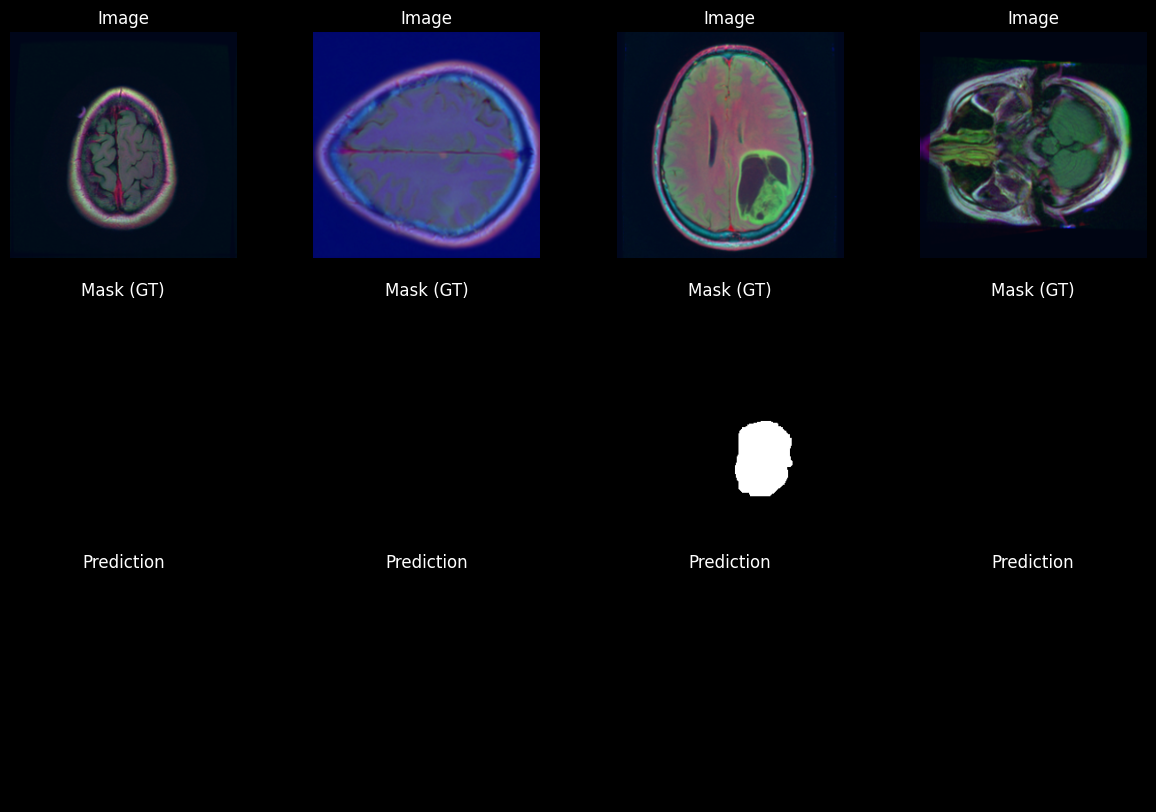

In [ ]:
### Start Code Here
model=torch.load('unet_model_ep_15.pth').to(DEVICE)
inference_pipeline(model,test_dataloader, DEVICE)
### End